# MSc Data Science - Advanced Machine Learning - Project 2: Reinforcement Learning
#### FCUL - Jan 2025

Faculty: Helena Aidos

Students:
- Duarte Valente fc64335
- Tu

## 0. Introduction - Mountain Car Environment

"Mountain Car is a classic reinforcement learning problem, often used as a benchmark for testing the performance of reinforcement learning algorithms. In this problem, an underpowered car must climb a steep hill to reach a goal located at the top of the hill. The car is subject to the laws of physics, which means that it cannot simply drive straight up the hill. Instead, it must build up speed by accelerating back and forth across the hill.

The state of the Mountain Car environment is represented by two continuous variables, the position and velocity of the car. The goal of the agent is to learn how to control the car's acceleration to climb the hill and reach the goal as quickly as possible while using the least amount of energy. The agent receives a negative reward for every step it takes to reach the goal, so the goal is to minimise the number of steps required to reach the goal."



## 1. Training the Q-Learning Agent

In [1]:
import gymnasium as gym
import numpy as np
import random

#### 1.1. Loading Environment

In [2]:
env = gym.make('MountainCar-v0')

#### 1.2. Discretizing the observation space

We have learned that the reinforcement learning environment can be modelled as a Markov decision process (MDP), and an MDP consists of the following:

* **States** - A set of states present in the environment. A state space consists of all of our states. We can obtain the number of states in our environment by just typing `env.observation_space`
* **Actions** - A set of actions the agent can perform in each state.
* **Reward function** - Reward function is denoted by $R(s,a,s')$. It implies the reward the agent obtains moving from a state $s$ to the state $s'$ while performing an action $a$.

In [3]:
print(env.observation_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [4]:
# The action space consists of all the possible actions in the environment.

position_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=20)
velocity_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=20)

def discretize_state(state):
    position, velocity = state
    position_idx = np.digitize(position, position_bins) - 1
    velocity_idx = np.digitize(velocity, velocity_bins) - 1
    return (position_idx, velocity_idx)

print(env.action_space.n) # Mountain Car - Discrete has 3 possible actions.

3


In the mountain car we have 3 discrete states in our state space: accelerating, deaccelerating and static. These states will be encoded as a number, from 0 to 2.

#### 1.3 Implementing Epsilon-Greedy

Let's define the dictionary for storing the Q value of the state-action pair, and we initialize the Q value of all the state-action pair to 0.0:

In [5]:
Q = np.zeros(((len(position_bins), len(velocity_bins), env.action_space.n)))

print(Q.shape) # 3D matrix 20*20 (Dimentions) * 3 (Possible Actions)

(20, 20, 3)


In [6]:
def epsilon_greedy(state, epsilon):
    #seed(1)
    r = random.random()
    
    if r < epsilon:
        #a= env.unwrapped.P[random()][random()]
        return random.choice(range(env.action_space.n))
    else:
        return np.argmax(Q[state])

epsilon_greedy(1, 0.1)

0

#### 1.4 Implementing the Q-learning algorithm
Initialize the discount factor $\gamma$ and the learning rate $\alpha$ and epsilon value. Set the number of episodes and number of time steps in the episode.

In [7]:
# Set Params

alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
num_episodes = 500000
rewards = []

Compute the optimal policy using the Q learning update rule as:

$Q(s,a) = Q(s,a) + \alpha (r + \gamma \max_{a'} Q(s',a') - Q(s,a))$

In [8]:
for episode in range(num_episodes):
    state = discretize_state(env.reset()[0])
    total_reward = 0

    for step in range(200):
        action = epsilon_greedy(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = discretize_state(next_state)

        # Q-learning update
        best_next_action = np.argmax(Q[next_state])
        Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])

        state = next_state
        total_reward += reward
        if done:
            break

    rewards.append(total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if episode % 2000 == 0:
        print(f"Episode {episode}, Reward: {total_reward}")

Episode 0, Reward: -200.0
Episode 2000, Reward: -200.0
Episode 4000, Reward: -200.0
Episode 6000, Reward: -150.0
Episode 8000, Reward: -145.0
Episode 10000, Reward: -141.0
Episode 12000, Reward: -156.0
Episode 14000, Reward: -142.0
Episode 16000, Reward: -141.0
Episode 18000, Reward: -139.0
Episode 20000, Reward: -200.0
Episode 22000, Reward: -147.0
Episode 24000, Reward: -147.0
Episode 26000, Reward: -126.0
Episode 28000, Reward: -141.0
Episode 30000, Reward: -109.0
Episode 32000, Reward: -136.0
Episode 34000, Reward: -145.0
Episode 36000, Reward: -133.0
Episode 38000, Reward: -132.0
Episode 40000, Reward: -153.0
Episode 42000, Reward: -137.0
Episode 44000, Reward: -160.0
Episode 46000, Reward: -184.0
Episode 48000, Reward: -142.0
Episode 50000, Reward: -146.0
Episode 52000, Reward: -138.0
Episode 54000, Reward: -130.0
Episode 56000, Reward: -144.0
Episode 58000, Reward: -138.0
Episode 60000, Reward: -152.0
Episode 62000, Reward: -140.0
Episode 64000, Reward: -134.0
Episode 66000, Rew

#### 1.5 Validating the agent measure

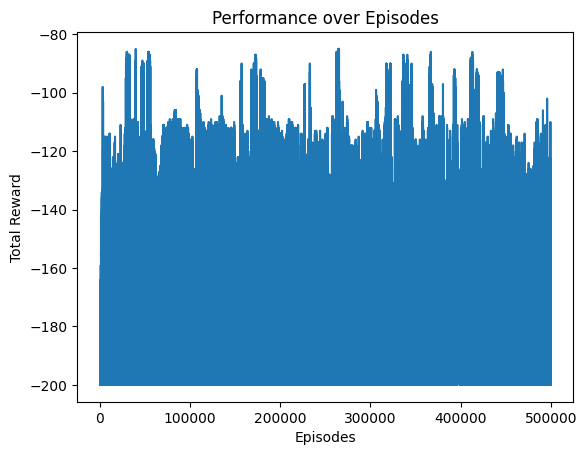

In [9]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Performance over Episodes')
plt.show()

In [10]:
print("Best Reward Obtained:", max(rewards))

Best Reward Obtained: -85.0


## 2. Training the DQN Agent

In this part of the project we will be performing **Deep Reinforcement Learning using JAX**, a library for array-oriented computation that enables high-performance machine learning research. Although Deep Reinforcement Learning can be computationally expensive and data-intensive, it is a powerful framework for solving problems where explicit programming or rule-based approaches fall short.

Similarly to Q-learning, DQN agents are defined by two functions: `act` and `update`.
- `act` function: implements an epsilon-greedy policy with respect to Q-values and the agent selects the action corresponding to the **maximum predicted Q-value** for a given state, with a set probability of acting randomly.
- `update` function: responsible for training the network: $$L(\theta)=E\left[ (r+(1-done) \times \gamma \max_{a'} Q(s',a';\theta^-) - Q(s,a;\theta))^2 \right],$$ where $\theta$ denotes the **parameters of the online network** and $\theta^-$ represents the **parameters of the target network**. Training is stabilized due to this separation of parameters.

In [11]:
import gymnax
import jax
import time
from RLinJAX import *
from RLinJAX.evaluate import evaluate
from matplotlib import pyplot as plt

In [12]:
# Using GPU
print(jax.devices())

[CudaDevice(id=0)]


#### 2.1 Creating a Gymnax environment: Mountain Car

This time we will be using `gymnax` intead of `gym` as it is ideal for applications like meta-reinforcement learning. It provides precise functional control over environment settings, such as random seeds and hyperparameters, and enables parallelized rollouts across different configurations.

In [13]:
# Add some randomness to the environment while keeping the option to make it reproductible. 
rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

# create the Mountain Car environment
env, env_params = gymnax.make('MountainCar-v0')
# inspect default environment settings
print(env_params)

EnvParams(max_steps_in_episode=200, min_position=-1.2, max_position=0.6, max_speed=0.07, goal_position=0.5, goal_velocity=0.0, force=0.001, gravity=0.0025)


As it is the same environment used in Q-Learning Training, there is no need to check the observation and action spaces.

In [14]:
obs, state = env.reset(key_reset, env_params)

action = env.action_space(env_params).sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)
n_obs, n_state, reward, done

/home/valentxi/miniconda3/envs/RL/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


(Array([-5.8331072e-01, -5.5867527e-04], dtype=float32),
 EnvState(time=Array(1, dtype=int32, weak_type=True), position=Array(-0.5833107, dtype=float32), velocity=Array(-0.00055868, dtype=float32)),
 Array(-1., dtype=float32, weak_type=True),
 Array(False, dtype=bool))

#### 2.2 Setting DQL Parameters

In [15]:
CONFIGS = {"dqn":{"agent": "DuelingQNetwork",
                  "agent_kwargs": {"activation": "swish"},
                  #"num_envs": 10,
                  "buffer_size": 50_000,
                  "fill_buffer": 10_000,
                  "batch_size": 256,
                  "learning_rate": 0.0005,
                  "polyak": 0.95,
                  "num_epochs": 5,
                  "target_update_freq": 1000,
                  "total_timesteps": 500_000,
                  "eval_freq": 5000,
                  "eps_start": 1,
                  "eps_end": 0.01,
                  "exploration_fraction": 0.3,
                  "gamma": 0.99,
                  "ddqn": True
                 }
          }

We will now create the algorithm instance for DQN in the MountainCar-v0 environment. 

In [16]:
algo_str = "dqn"
env_str = "MountainCar-v0"

# `get_algo` is a convenient function to access algorithms easily
# `alg_cls.create` creates a frozen instance of the algorithm and populates it with default values
algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

#### 2.3 Training DQL Agent

In [17]:
# set training seed and jit train function. Jit `algo.train` allows for faster execution
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train: the initial train_state holds currents environment step, network parameters and replay buffer contents
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train


/home/valentxi/miniconda3/envs/RL/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/home/valentxi/miniconda3/envs/RL/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 238.471 seconds (2096.69 steps/second).


In [18]:
print('Tuple size:', len(evaluation))
print('Episodic lengths and episodic returns shape:', evaluation[0].shape)
print(f"{algo.total_timesteps} / {algo.eval_freq} + 1 = {(algo.total_timesteps/algo.eval_freq+1)}")

Tuple size: 2
Episodic lengths and episodic returns shape: (101, 128)
500000 / 5000 + 1 = 101.0


#### 2.4 Visualizing DQL Results

Learning Curve

In [19]:
train_state

DQNState(rng=Array([3849062537, 2780740907], dtype=uint32), env_state=EnvState(time=Array([107], dtype=int32, weak_type=True), position=Array([-1.0421695], dtype=float32), velocity=Array([-0.04977829], dtype=float32)), last_obs=Array([[-1.0421695 , -0.04977829]], dtype=float32), global_step=Array(500000, dtype=int32, weak_type=True), last_done=Array([False], dtype=bool), q_ts=TrainState(step=Array(2449995, dtype=int32, weak_type=True), apply_fn=(), params={'params': {'Dense_0': {'bias': Array([-2.8386412], dtype=float32), 'kernel': Array([[ 2.8427653e+00],
       [-7.5428904e-04],
       [ 3.4118392e+00],
       [ 2.6139703e-03],
       [ 3.3172135e+00],
       [ 2.0635476e+00],
       [-2.8836008e-03],
       [-1.0035356e-01],
       [ 2.0779110e-03],
       [ 1.7201484e-03],
       [ 4.4616661e+00],
       [-2.8754630e+00],
       [-5.7466386e-05],
       [ 9.4023770e-01],
       [ 5.4159382e-04],
       [ 1.2756538e-04],
       [ 2.8680391e+00],
       [ 2.2641444e-03],
       [ 2.9

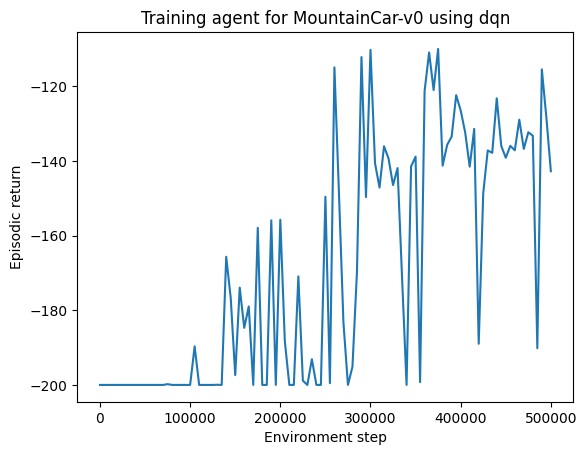

In [20]:
episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

Next, we will be looking at the `train_state`, to see what the algorithm produced.

checking best score

In [21]:
episode_lengths, episode_returns = evaluation
episode_returns.max(axis=1).max()

Array(-83., dtype=float32)

In [22]:
# Identify the best episode and its reward
best_idx = jax.numpy.argmin(episode_returns, axis=1)[0]
best_reward = episode_returns[best_idx, 0]
print(f"Best Episode Reward: {best_reward}")

Best Episode Reward: -200.0


##### Why is this here?

In [23]:
jax.tree_util.tree_map(lambda x: x.shape, train_state).__dict__

{'rng': (2,),
 'env_state': EnvState(time=(1,), position=(1,), velocity=(1,)),
 'last_obs': (1, 2),
 'global_step': (),
 'last_done': (1,),
 'q_ts': TrainState(step=(), apply_fn=(), params={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (3,), 'kernel': (64, 3)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7fd8607469e0>, update=<function chain.<locals>.update_fn at 0x7fd840102320>), opt_state=(ScaleByAdamState(count=(), mu={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (3,), 'kernel': (64, 3)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, nu={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (3,), 'kernel': (64, 3)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,),

`RLinJAX` allows for the use of the function `evaluate` to quickly and parallelly evaluate policies

In [24]:
# Algorithms return an agent's policy parameters in its train state. 
policy = algo.make_act(train_state)
policy = jax.jit(policy)

In [25]:
num_seeds = 200  
env, params = gymnax.make(env_str)
max_steps = params.max_steps_in_episode

start = time.time()

# Evaluate Policy
episode_lengths, episode_returns = evaluate(policy, rng, env, params, num_seeds, max_steps)

time_elapsed = time.time() - start

print(
    f"Evaluated {num_seeds} episodes "
    f"with a total of {jax.numpy.sum(episode_lengths)} environment steps "
    f"in {time_elapsed:g} seconds."
)

avg_return = jax.numpy.mean(episode_returns)
print(f"Average Episode Return: {avg_return}")

best_return = jax.numpy.max(episode_returns)
print("Best Return:", best_return)

success_rate = jax.numpy.sum(jax.numpy.array(episode_returns) > -200) / num_seeds
print(f"Success Rate: {success_rate * 100:.2f}%")

Evaluated 200 episodes with a total of 28485 environment steps in 0.892195 seconds.
Average Episode Return: -142.4250030517578
Best Return: -87.0
Success Rate: 95.50%


[Text(0.5, 1.0, 'Episode return')]

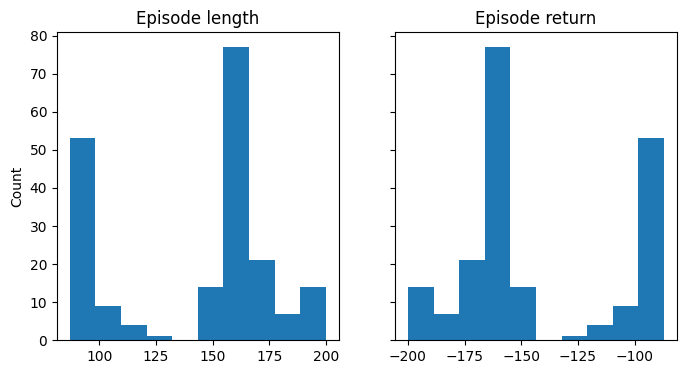

In [26]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharey="row")

axes[0].hist(episode_lengths, bins=10)
axes[0].set(title="Episode length", ylabel="Count")
axes[1].hist(episode_returns)
axes[1].set(title="Episode return")

## 2. Training the SAC Agent

In this part of the project we will be performing **Deep Reinforcement Learning using JAX**, a library for array-oriented computation that enables high-performance machine learning research. Although Deep Reinforcement Learning can be computationally expensive and data-intensive, it is a powerful framework for solving problems where explicit programming or rule-based approaches fall short.

In contrast with both `Q-Learning` and `DQL`, Soft Actor-Critic, `SAC` is ready for a continuous action space, something that doesn't happen in MountainCar-V0 environment, where there are only 3 discrete actions. 

The group searched for solutions and found that there was a version of `SAC` that was ready for a discrete action space, `SAC-Discrete`. However, we ended up not using this algorithm and instead switched to the continuous version of the environment, *MountainCarContinuous* because the available version of RLinJAX, that we where told to use on the assignment didn't include any training agent equivalent to `SAC-Discrete` and although we found some versions of SAC-Discrete online we thouhght we weren't supposed to use external libraries or to adapt the given SAC to SAC-Discrete.

Because of this, we decided to simply alter the environment and get less relevant results for an overall analysis at the gain that we got the code up and running.

#### 2.1 Creating a Gymnax environment: Mountain Car Continuous

This time we will be using `gymnax` intead of `gym` as it is ideal for applications like meta-reinforcement learning. It provides precise functional control over environment settings, such as random seeds and hyperparameters, and enables parallelized rollouts across different configurations.

The Mountain Car Continuous Environment is simmilar to Mountain Car exept for the fact that it isn't discretely limited on what actions it can take. Essentially the acceleration of the car can take any value betwheen -1 and 1 instead of the [-1, 0, 1] options in the discrete version of the env. 

In [27]:
rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

# create the Mountain Car environment
env, env_params = gymnax.make('MountainCarContinuous-v0')
# inspect default environment settings
env_params

EnvParams(max_steps_in_episode=999, min_action=-1.0, max_action=1.0, min_position=-1.2, max_position=0.6, max_speed=0.07, goal_position=0.45, goal_velocity=0.0, power=0.0015, gravity=0.0025)

In [28]:
print(env.observation_space(env_params).shape)

(2,)


In [29]:
# This Error happens because the environment's action space is continuous, therefore we can't put a number on the ammount of possible actions.
print(env.action_space(env_params).n)

AttributeError: 'Box' object has no attribute 'n'

In [30]:
obs, state = env.reset(key_reset, env_params)
obs, state

(Array([-0.58275205,  0.        ], dtype=float32),
 EnvState(time=Array(0, dtype=int32, weak_type=True), position=Array(-0.58275205, dtype=float32), velocity=Array(0., dtype=float32, weak_type=True)))

In [31]:
action = env.action_space(env_params).sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)
n_obs, n_state, reward, done

(Array([-0.5808441 ,  0.00190795], dtype=float32),
 EnvState(time=Array(1, dtype=int32, weak_type=True), position=Array(-0.5808441, dtype=float32), velocity=Array(0.00190795, dtype=float32)),
 Array(-0.09559999, dtype=float32),
 Array(False, dtype=bool))

#### 2.2 Setting SAC Parameters

In [32]:
CONFIGS = {"sac":{
                  #"num_envs": 10,
                  "buffer_size": 100_000,
                  "batch_size": 256,
                  "learning_rate": 0.00001,
                  "polyak": 0.95,
                  "num_epochs": 5,
                  "target_update_freq": 1000,
                  "total_timesteps": 500_000,
                  "eval_freq": 5000,
                  "gamma": 0.99,
                 }
          }

In [33]:
algo_str = "sac"
env_str = "MountainCarContinuous-v0"

# `get_algo` is a convenient function to access algorithms easily
# `alg_cls.create` creates a frozen instance of the algorithm and populates it with default values
algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

#### 2.3 Training SAC Agent

In [34]:
# set training seed and jit train function. Jit `algo.train` allows for faster execution
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train: the initial train_state holds currents environment step, network parameters and replay buffer contents
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train
Finished training in 299.929 seconds (1667.06 steps/second).


In [35]:
print('Tuple size:', len(evaluation))
print('Episodic lengths and episodic returns shape:', evaluation[0].shape)
print(f"{algo.total_timesteps} / {algo.eval_freq} + 1 = {(algo.total_timesteps/algo.eval_freq+1)}")

Tuple size: 2
Episodic lengths and episodic returns shape: (101, 128)
500000 / 5000 + 1 = 101.0


Get Highest Reward

In [36]:
episode_lengths, episode_returns = evaluation
episode_returns.max(axis=1).max()

Array(85.899994, dtype=float32)

#### 2.4 Visualizing DQL Results

Checking SAC Learning Curve

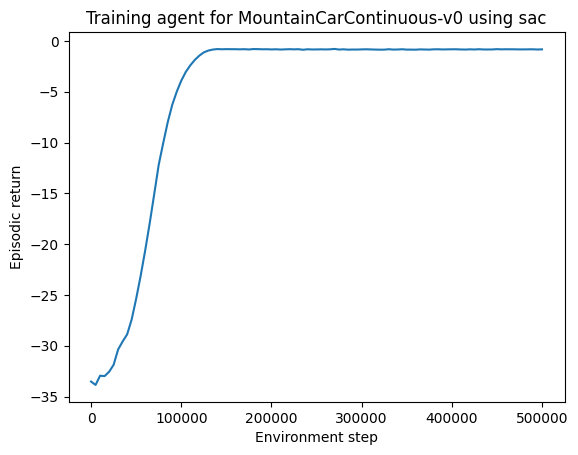

In [37]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

In [38]:
policy = algo.make_act(train_state)
policy = jax.jit(policy)

In [39]:
# Algorithms return an agent's policy parameters in its train state. 
policy = algo.make_act(train_state)
policy = jax.jit(policy)

In [40]:
from RLinJAX.evaluate import evaluate

num_seeds = 200  
env, params = gymnax.make(env_str)
max_steps = params.max_steps_in_episode

rng = jax.random.PRNGKey(0)

start = time.time()

# Evaluation time!
episode_lengths, episode_returns = evaluate(policy, rng, env, params, num_seeds, max_steps)

time_elapsed = time.time() - start

print(
    f"Evaluated {num_seeds} episodes "
    f"with a total of {jax.numpy.sum(episode_lengths)} environment steps "
    f"in {time_elapsed:g} seconds."
)

avg_return = jax.numpy.mean(episode_returns)
print(f"Average Episode Return: {avg_return}")

success_rate = jax.numpy.sum(jax.numpy.array(episode_returns) > -200) / num_seeds
print(f"Success Rate: {success_rate * 100:.2f}%")

Evaluated 200 episodes with a total of 199800 environment steps in 1.35233 seconds.
Average Episode Return: -0.818238377571106
Success Rate: 100.00%


The histograms aren't usefull on a continuous action space

[Text(0.5, 1.0, 'Episode return')]

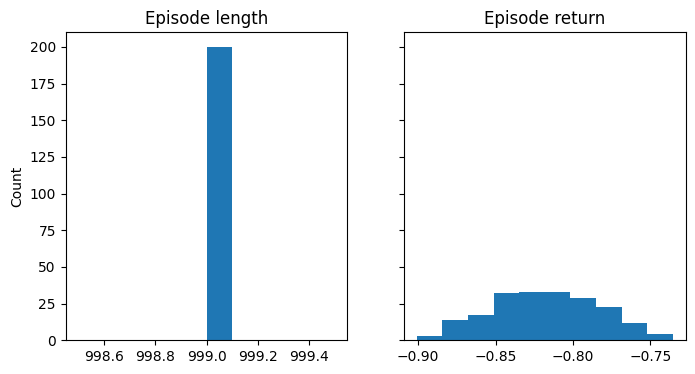

In [41]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharey="row")

axes[0].hist(episode_lengths, bins=10)
axes[0].set(title="Episode length", ylabel="Count")
axes[1].hist(episode_returns)
axes[1].set(title="Episode return")